<b><h1>Facial Emotion Recogniton

In [1]:
# importing all the neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import Callback, EarlyStopping

import scikitplot
import seaborn as sns
from sklearn.model_selection  import train_test_split
from sklearn.metrics import classification_report, accuracy_score

Init Plugin
Init Graph Optimizer
Init Kernel


<b>1. Подготовим данные (датасет взят c kaggle.com)

In [2]:
data = pd.read_csv('./fer2013.csv')
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
img_width, img_height = 48, 48

# getting only the second column with raw pixels and converting it to list
pixel_rows = data['pixels'].tolist()

# converting each value of every row to int and eventually to 
X = []
for pixel_row in pixel_rows:
    px_r = []
    for p in pixel_row.split(' '):
        px_r.append(int(p))
    px_r = np.asarray(px_r).reshape(img_width, img_height)
    X.append(px_r.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

# getting labels
Y = pd.get_dummies(data['emotion']).to_numpy()

print("Total num of entries: {}".format( str(len(X))))
print("Num of features: {}".format( str(len(X[0]))))
print("Num of classes: {}".format( str(len(Y[0]))))

Total num of entries: 35887
Num of features: 48
Num of classes: 7


In [4]:
# Normalazing the data set
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

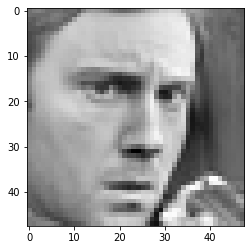

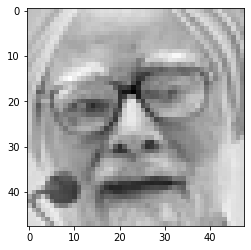

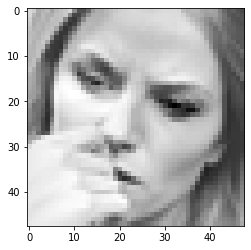

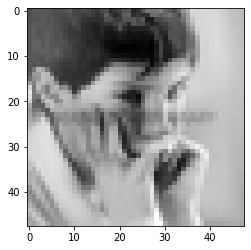

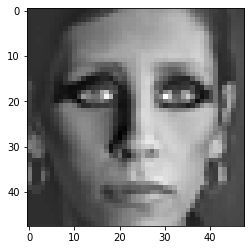

In [5]:
# Plotting 5 examples of the data set
for i in range(5):
    plt.figure(i)
    plt.imshow(X[i].reshape((48, 48)), interpolation='none', cmap='gray')
plt.show()

In [6]:
# Splitting the data set into train validation and test sets
# 20 % ratio  for valid and test datasets it's too much 

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y,
                                       test_size=0.1,
                                       shuffle=True, random_state=41)

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train,
                                       test_size=0.1,
                                       shuffle=True, random_state=41)

print(X_train.shape, X_valid.shape, X_test.shape)

(29068, 48, 48, 1) (3589, 48, 48, 1) (3230, 48, 48, 1)


<b>2. Теперь опишем архитектуру сети

Сеть имеет:

* 6 сверточных слоев 
* 1 полносвязаный Dense слой со 64 выходами
* слой разворачивания - принимает 64 карты признаков 3x3 и выдает вектор  1 x 3 * 3 * 64
* выходной слой с 7 перцептронами (выходами) с функцией активации softmax (мультиклассификация) 
* optimizer - adam
* loss функция - categorical_crossentropy

Дополнительные особенности архитектуры нейронной сети: 

* размер ядра (фильтра)  3 * 3
* функция активации на каждом сверточном слое - relu
* батч нормализация, после каждого слоя 
* функция активации relu после каждого слоя
* добавлен  1 Dropout слой с вероятностью 0.15
* pooling ( MaxPooling) 2 x 2
* был добавлен сallback для ранней остановки модели
* обучение по минибатчам ( с размером 32)

In [24]:
def build_model():
    model = Sequential()
    
    model.add(
        Conv2D(
            filters = 256,
            kernel_size = (3,3),
            input_shape = ( 48, 48, 1) ,
            activation = 'relu',
            padding = 'same' 
        )
    )
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(
        Conv2D(
            filters = 256,
            kernel_size = (3,3),
            activation = 'relu',
            padding = 'same' 
        )
    )
    
        
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(
        Conv2D(
            filters = 128,
            kernel_size = (3,3),
            activation = 'relu',
            padding = 'same' 
        )  
    )
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(
        Conv2D(
            filters = 128,
            kernel_size = (3,3),
            activation = 'relu',
            padding = 'same' 
        )
    )
        
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    
    model.add(
        Conv2D(
            filters =  64,
            kernel_size = (3, 3),
            activation = 'relu',
            padding = 'same' 
        )  
    )
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(
        Conv2D(
            filters = 64,
            kernel_size = (3, 3),
            activation = 'relu',
            padding = 'same' 
        )
    )
        
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(
        Dense(
            64,
            activation='relu',
        )
    )
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(
        Dropout(0.15)
    )
    
    model.add(
        Dense(
            7,
            activation='softmax',
        )
    )
    
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam( learning_rate = 0.001 ),
        metrics=['accuracy']
    )
    
    model.summary()
     
    return model

<b>3. Проведем тренеровку нейросети

In [25]:
model = build_model() 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 256)       2560      
_________________________________________________________________
batch_normalization_7 (Batch (None, 48, 48, 256)       1024      
_________________________________________________________________
activation_7 (Activation)    (None, 48, 48, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 256)       590080    
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 48, 256)       1024      
_________________________________________________________________
activation_8 (Activation)    (None, 48, 48, 256)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 256)      

Добавим callback для ранней остановки во избежании пееробучения

In [9]:
callback = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=0.00005,
        patience=11,
        verbose=1,
        restore_best_weights=True)
]

In [10]:
batch_size = 32 # batch size of 32 performs the best
epochs = 150


model.fit( X_train, Y_train,
         validation_data = (X_valid, Y_valid),
         epochs = epochs,
         batch_size = batch_size,
         verbose = 1,
         callbacks = callback,
         shuffle = True)


2022-01-02 07:51:23.549833: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-02 07:51:23.552547: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/150


2022-01-02 07:51:23.814751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


909/909 [==============================] - ETA: 0s - loss: 1.5567 - accuracy: 0.4026

2022-01-02 07:55:20.945129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


909/909 [==============================] - 245s 269ms/step - loss: 1.5567 - accuracy: 0.4026 - val_loss: 1.5893 - val_accuracy: 0.4232
Epoch 2/150
909/909 [==============================] - 243s 267ms/step - loss: 1.2638 - accuracy: 0.5202 - val_loss: 1.2552 - val_accuracy: 0.5302
Epoch 3/150
909/909 [==============================] - 239s 263ms/step - loss: 1.1160 - accuracy: 0.5809 - val_loss: 1.1851 - val_accuracy: 0.5645
Epoch 4/150
909/909 [==============================] - 240s 264ms/step - loss: 1.0134 - accuracy: 0.6222 - val_loss: 1.1952 - val_accuracy: 0.5598
Epoch 5/150
909/909 [==============================] - 239s 263ms/step - loss: 0.9183 - accuracy: 0.6564 - val_loss: 1.1653 - val_accuracy: 0.5756
Epoch 6/150
909/909 [==============================] - 241s 266ms/step - loss: 0.7806 - accuracy: 0.7090 - val_loss: 1.1404 - val_accuracy: 0.5999
Epoch 7/150
909/909 [==============================] - 246s 271ms/step - loss: 0.6518 - accuracy: 0.7620 - val_loss: 1.2207 - val_

Сохраним модель после обучения для дальнейшего использования

In [14]:
model_yaml = model.to_yaml()

with open("fer_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

<b>4. Протестируем полученную модель


In [13]:
test_true = np.argmax(Y_test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.5929


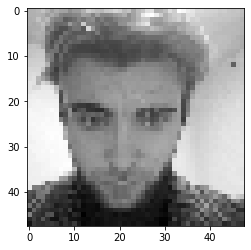

Predicted value: neutral


In [23]:
from skimage import io

emotions = ('angrer', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral')

img = image.load_img("./img.png", grayscale=True, target_size=(48, 48))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

# normalize
x /= 255

# make a prediction
pred = model.predict(x)
index = np.argmax(pred[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

# plotting
plt.gray()
plt.imshow(img)
plt.show()

print('Predicted value:', emotions[index])

<b>5. Выводы


In [ ]:
По результатам обучения точность предсказания модели на валидационном датасете составляет 59 процентов - что в довольно неплохо.
Безусловно , точность предсказания  можно улучшить. Один из возможных способов - это увеличить размера датасета 
Так как датасет, который использовался для обучения - относительно небольшой ( 35887 примеров) модель склонна к переобучению 
( при больщом кол-ве итераций начинает запоминать примеры ).
Одна из возможных мер решения данной проблемы ( переобучения) - добавление в архитектуру  сети  dropout слой.
Что собственно и было сделано, но это незначительно улучшило точность предсказания ( примерно на 5 процентов)
Была сделана попытка увеличить/уменьшить размер минибатча (с 32) до 64 и 16 соответсвенно - результаты в обоих случаях оказались хуже.
Еще можно попробовать добавить регуляризацию L1 L2 и посмотреть в сторону изменения архитектуры сети.